In [1]:
import glob
import gzip
import os
import shutil
import sys
import time
from datetime import date
import numpy as np
import pandas as pd
import copy

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def datetime_to_seconds(dates, ref="1900-01-01T00:00:00"):
    """from datetime64 to seconds since 1900-01-01 00:00:00"""
    return ((dates - np.datetime64(ref)) / np.timedelta64(1, "s")).astype(np.int64)

def seconds_to_datetime(seconds, ref="1900-01-01"):
    """from seconds to datetime64"""
    seconds = np.asarray(seconds)
    return pd.to_datetime(seconds, unit="s", origin=ref)

import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt

matplotlib.rcParams.update({"font.size": 20})
matplotlib.rcParams["figure.figsize"] = (20, 10)

In [2]:
import cv2
import numpy as np
from tkinter import Tk, filedialog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
import pytesseract

pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

## CV2

In [42]:
def digitize(file, height_input = False):  
    matplotlib.rcParams["figure.figsize"] = (4, 3)
    # try:
    %matplotlib inline
    print(file)
    # Load the image
    img = cv2.imread(file)
    # plt.imshow(img)
    # plt.show()
    # plt.close()

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply a threshold to create a binary image
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Find the contours in the binary image
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Find the contour with the largest area (i.e., the plot data)
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding box of the contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image to the bounding box
    plot_only = img[y+10:y+h-1, x+1:x+w-1]
    relative_y = y+10
    relative_x = x+1
    relative_y_xaxis =  y+h-1

    # Save the cropped image
    cv2.imwrite('test_plot_only.png', plot_only)

    # Show the cropped image
    # plt.imshow(plot_only)
    # plt.show()

    # Convert the contour to a numpy array and transpose it
    plot_data = largest_contour.squeeze().T

    # Print the plot data
    # print(plot_data)

    

    image = img[ 1272:1285, 20:500]
    # plt.imshow(image)
    # plt.show()
    # plt.close()
    if np.mean(image) == 255:
        print('All white')
        return 0

    image_l = image_resize(image, height = 50)
    gray = cv2.cvtColor(image_l, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Morph open to remove noise and invert image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    inverted = 255 - opening

    data = pytesseract.image_to_string(inverted, lang='eng', config= '--psm 7')



    im = cv2.imread("test_plot_only.png")

    # Define lower and upper limits of our blue
    BlueMax = np.array([128, 255, 255], np.uint8)
    BlueMin = np.array([90, 50, 70], np.uint8)

    # Go to HSV colourspace and get mask of blue pixels
    HSV = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    # plt.imshow(HSV)
    # plt.show()
    # plt.close()
    mask = cv2.inRange(HSV, BlueMin, BlueMax)

    # Make all pixels in mask white
    grid = copy.copy(im)
    grid[mask == 0] = [255, 255, 255]
    grid[0:, 0:15] = [255, 255, 255]


    im[mask > 0] = [255, 255, 255]
    im[0:100, 0:15] = [255, 255, 255]
    im[-2:, :] = [255, 255, 255]

    # plt.imshow(im)
    # plt.show()
    # plt.close()
    # plt.imshow(grid)
    # plt.show()
    # plt.close()
    cv2.imwrite("test_grid_only.png", grid)
    cv2.imwrite("test_data_only.png", im)



    # print("Analyzig grid:")

    grid = cv2.imread('test_grid_only.png')
    gray = cv2.cvtColor(grid, cv2.COLOR_BGR2GRAY)

    gray = np.float32(gray)

    dst = cv2.cornerHarris(gray, 5,19,0.07)
    dst = cv2.dilate(dst, None)

    # Get coordinates
    ret, dst = cv2.threshold(dst, 0.1 * dst.max(), 255, 0)
    dst = np.uint8(dst)

    # find centroids
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    # define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 
                0.001)
    corners = cv2.cornerSubPix(gray,np.float32(centroids[1:]),(5,5), 
          (-1,-1),criteria)
    # To draw the corners
    for corner in corners:
        grid[int(corner[1]), int(corner[0])] = [0, 0, 255]
    corner_coords = np.asarray(corners, dtype = int)
    corner_coords = corner_coords[corner_coords[:,0] < np.max(corner_coords[:,0]) * 0.9]
    corner_coords = corner_coords[corner_coords[:,1] < np.max(corner_coords[:,1]) * 0.9]
    corner_coords = corner_coords[corner_coords[:,0] > np.max(corner_coords[:,0]) * 0.1]
    corner_coords = corner_coords[corner_coords[:,1] > np.max(corner_coords[:,1]) * 0.1]
    for co in corner_coords:
        grid = cv2.circle(grid, co, radius=4, color=(255, 0, 0), thickness=-1)
    # plt.imshow(grid)
    # plt.show()
    # plt.close()



    # choosing 2 points
    grid = cv2.imread('test_grid_only.png')
    # not on the very outside of the plot:
    maxcoord = np.argmax(np.sum(corner_coords, axis = 1))
    mincoord = np.argmin(np.sum(corner_coords, axis = 1))

    # coords_mean = meancoord
    coords_low = corner_coords[mincoord]
    coords_high = corner_coords[maxcoord]
    grid = cv2.circle(grid, coords_low, radius=4, color=(0, 0, 255), thickness=-1)
    grid = cv2.circle(grid, coords_high, radius=4, color=(0, 0, 255), thickness=-1)

    
    low_y_label = img[relative_y + coords_low[1]-10: relative_y + coords_low[1]+10, relative_x-45:relative_x-1]
    low_y_val = convert_label_y_2(low_y_label, show_input = False, show_plots = False)
    print(low_y_val)
    
    high_y_label = img[relative_y + coords_high[1]-10: relative_y + coords_high[1]+10, relative_x-45:relative_x-1]
    high_y_val = convert_label_y_2(high_y_label, show_input = False, show_plots = False)
    print(high_y_val)

    low_x_label = img[relative_y_xaxis+1 : relative_y_xaxis+20, relative_x+coords_low[0]-20:relative_x+coords_low[0]+30]
    low_x_val = convert_label(low_x_label, show_input = False, show_plots = False)
    print(low_x_val)    
    
    high_x_label = img[relative_y_xaxis+1 : relative_y_xaxis+20, relative_x+coords_high[0]-30:relative_x+coords_high[0]+30]
    high_x_val = convert_label(high_x_label, show_input = False, show_plots = False)
    print(high_x_val)
    
    print()
    
    if low_x_val > 0 and low_x_val > high_x_val:
        low_x_val = str(float(low_x_val) * -1)
        print('changed to: ', low_x_val)


    
    # converting axis texts to data:
    # print('low: ',coords_low, low_x_val, low_y_val)
    # print('high: ',coords_high, high_x_val, high_y_val)
    xa_p = [coords_low[0], coords_high[0]]
    xa_v = [273.15+low_x_val, 273.15+high_x_val]
    ya_p = [coords_low[1], coords_high[1]]
    ya_v = [low_y_val, high_y_val]
    # display(xa_p)
    # display(xa_v)
    # display(ya_p)
    # display(ya_v)
    # print()

    
    # calculation of axis functions
    # x-axis
    x1 = xa_p[0]
    a = xa_v[0]
    x2 = xa_p[1]
    b = xa_v[1]

    m_T = (b - a) / (x2 - x1)
    c_T = a - m_T * x1
    def T(x):
        return m_T * x + c_T

    # y-axis
    if height_input:
        y1 = ya_p[0]
        ap = ya_v[0]
        y2 = ya_p[1]
        bp = ya_v[1]
    else: 
        y1 = ya_p[0]
        ap = np.log(ya_v[0])
        y2 = ya_p[1]
        bp = np.log(ya_v[1])

    m = (bp - ap) / (y2 - y1)
    c = ap - m * y1
    def P(x):
        return m * x + c

    
    # selection of data points via contour of graph:
    graph = cv2.imread('test_data_only.png')
    edge = cv2.Canny(graph, 30, 200) 
    ans = []
    for y in range(0, edge.shape[0]):
        for x in range(0, edge.shape[1]):
            if edge[y, x] != 0:
                ans = ans + [[x, y]]
    ans = np.array(ans)

    # print(ans.shape)
    # print(ans[0:10, :])

    for co in ans[:]:
        image = cv2.circle(graph, co, radius=4, color=(255, 0, 0), thickness=-1)
    # plt.imshow(image)
    # plt.show()
    # plt.close()


    unique_steps = []
    for i in range(np.min(ans[:,1]), np.max(ans[:,1])+1):
        step = ans[ans[:,1] == i]
        if len(step) > 1:
            mean_step = (np.mean(step, axis=0))
            unique_steps.append([int(mean_step[0]), int(mean_step[1])])
        elif len(step) == 1:
            unique_steps.append([int(step[0][0]), (step[0][1])])
    unique_steps


    # points to data with functions:
    out = {}
    # out['press'] = np.exp(P(ans[0::20][:,1]))
    # out['temp'] = (T(ans[0::20][:,0]))
    if height_input:
        out['press'] = P(np.array(unique_steps)[:,1])
    else:
        out['press'] = np.exp(P(np.array(unique_steps)[:,1]))
    out['temp'] = T(np.array(unique_steps)[:,0])
    df = pd.DataFrame.from_dict(out)
    df = df.sort_values('press')
    if height_input:
        df.to_csv('./out_height_zoomed/' + file.split('sc_')[-1].split('.png')[0]+'.csv')
    else:
        df.to_csv('./out_data/' + file.split('sc_')[-1].split('.png')[0]+'.csv')
    # except Exception as e:
    #     print(str(e))
    #     return 0
    return df

In [43]:
def convert_label(label, show_input = False, show_plots = False):
    out = []
    set_psm =  '--psm 6 --oem 3 -c tessedit_char_whitelist=0123456789-,._C preserve_interword_spaces=1' #'--psm 6' # 'outputbase digits'

    if show_input:
        plt.imshow(label)
        plt.show()
        plt.close()
        
    # label = cv2.imread('./large_40.png')
    label = image_resize(label, height=100, inter=cv2.INTER_CUBIC)


    gray = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    thresh_val = 50
    thresh = cv2.threshold(blur, thresh_val, thresh_val, cv2.THRESH_BINARY)[1]
    edges = cv2.Canny(thresh,100,200)
    vertical_sum = np.sum(edges, axis=0)
    vertical_sum = vertical_sum != 0
    changes = np.logical_xor(vertical_sum[1:], vertical_sum[:-1])
    change_pts = np.nonzero(changes)[0]
    if show_plots:
        print('character detection')
        plt.imshow(thresh)
        for change in change_pts:
            plt.axvline(change+1)
        plt.show()
        plt.close()

    for i in range(len(change_pts)-1):
        start = change_pts[i]
        end =  change_pts[i+1]
        if start != end and end-start > 10:
            cut = label[:, start:end]
            cut = cv2.copyMakeBorder(
                     cut, 
                     1, 
                     1, 
                     20, 
                     20, 
                     cv2.BORDER_CONSTANT, 
                     value= [175,175,175]
                  )
            # plt.imshow(cut)
            # plt.show()
            # plt.close()

            gray = cv2.cvtColor(cut, cv2.COLOR_BGR2GRAY)
            blur = cv2.GaussianBlur(gray, (5,5), 0)
            thresh = cv2.threshold(blur, 255, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

            # Morph open to remove noise and invert image
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
            opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
            inverted = 255 - opening
            if show_plots:
                plt.imshow(inverted)
                plt.show()
                plt.close()
    #         inverted = image_resize(inverted, height = 50)
            out_val = pytesseract.image_to_string(inverted, lang='eng', config= set_psm)
            if out_val == '\x0c':
                out.append('-')
            else:
                out.append( out_val.split('\n\x0c')[0])
    return_str = ''.join(out)
    minus_signs = [pos for pos, char in enumerate(return_str) if char == '-']
    if (minus_signs != [0]) and (minus_signs != []):
        plt.imshow(label)
        plt.show()
        plt.close()
        print(minus_signs)
        return_str = input('please help me read this lable: ')
    
    return float(return_str)

    
def convert_label_y(label, show_input = False):
    rs_h = 50
    set_psm =  '--psm 6 --oem 3 -c tessedit_char_whitelist=0123456789-,._C preserve_interword_spaces=1'
    if show_input:
        plt.imshow(label)
        plt.show()
        plt.close()
    
    label = image_resize(label, height = rs_h, inter=cv2.INTER_CUBIC)

    gray = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Morph open to remove noise and invert image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    inverted = 255 - opening

    val = pytesseract.image_to_string(inverted, lang='eng', config= set_psm)
    val = "".join([x for x in val.replace('.', '').split('\n\x0c')[0]])
    if len(val) < 3:
        val = float(val)*1000
    else:
        val = float(val)
    return val

def convert_label_y_2(label, show_input = False, show_plots = False):
    out = []
    set_psm =  '--psm 6 --oem 3 -c tessedit_char_whitelist=0123456789-,._C preserve_interword_spaces=1' #'--psm 6' # 'outputbase digits'

    if show_input:
        plt.imshow(label)
        plt.show()
        plt.close()
        
    # label = cv2.imread('./large_40.png')
    label = image_resize(label, height=100, inter=cv2.INTER_CUBIC)


    gray = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    thresh_val = 50
    thresh = cv2.threshold(blur, thresh_val, thresh_val, cv2.THRESH_BINARY)[1]
    edges = cv2.Canny(thresh,100,200)
    vertical_sum = np.sum(edges, axis=0)
    vertical_sum = vertical_sum != 0
    changes = np.logical_xor(vertical_sum[1:], vertical_sum[:-1])
    change_pts = np.nonzero(changes)[0]
    if show_plots:
        print('character detection')
        plt.imshow(thresh)
        for change in change_pts:
            plt.axvline(change+1)
        plt.show()
        plt.close()

    for i in range(len(change_pts)-1):
        start = change_pts[i]
        end =  change_pts[i+1]
        if start != end and end-start > 10:
            cut = label[:, start:end]
            cut = cv2.copyMakeBorder(
                     cut, 
                     1, 
                     1, 
                     20, 
                     20, 
                     cv2.BORDER_CONSTANT, 
                     value= [175,175,175]
                  )
            # plt.imshow(cut)
            # plt.show()
            # plt.close()

            gray = cv2.cvtColor(cut, cv2.COLOR_BGR2GRAY)
            blur = cv2.GaussianBlur(gray, (5,5), 0)
            thresh = cv2.threshold(blur, 255, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

            # Morph open to remove noise and invert image
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
            opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
            inverted = 255 - opening
            if show_plots:
                plt.imshow(inverted)
                plt.show()
                plt.close()
    #         inverted = image_resize(inverted, height = 50)
            out_val = pytesseract.image_to_string(inverted, lang='eng', config= set_psm)
            if out_val == '\x0c':
                out.append('')
            else:
                out.append( out_val.split('\n\x0c')[0])
    return_str = ''.join(out)
    minus_signs = [pos for pos, char in enumerate(return_str) if not np.isin(char, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])]
    if (minus_signs != [0]) and (minus_signs != []):
        plt.imshow(label)
        plt.show()
        plt.close()
        print(minus_signs)
        return_str = input('please help me read this lable: ')
    if len(return_str) < 3:
        val = float(return_str)*1000
    else:
        val = float(return_str)
    return val


./height_data_zoomed/sc_Vaisala_4_3_.png
20000.0
16000.0
-79.0
-70.0

./height_data_zoomed/sc_Vaisala_4_0_.png
34500.0
31000.0
-44.0
-33.0

./height_data_zoomed/sc_Vaisala_4_2_.png
25000.0
21000.0
-70.0
-54.0

./height_data_zoomed/sc_Vaisala_4_5_.png
10000.0
6000.0
-32.0
-2.0

./height_data_zoomed/sc_Vaisala_4_6_.png
4500.0
1000.0
0.0
20.0

./height_data_zoomed/sc_Vaisala_4_1_.png
30000.0
26000.0
-55.0
-46.0

./height_data_zoomed/sc_Vaisala_4_4_.png
15000.0
11000.0
-70.0
-35.0

./height_data_zoomed/sc_Vaisala_5_4_.png
14000.0
11000.0
-72.0
-34.0

./height_data_zoomed/sc_Vaisala_5_0_.png
33500.0
30000.0
-45.0
-38.0

./height_data_zoomed/sc_Vaisala_5_3_.png
19000.0
16000.0
-81.0
-70.0

./height_data_zoomed/sc_Vaisala_5_1_.png
29000.0
26000.0
-57.0
-46.0

./height_data_zoomed/sc_Vaisala_5_6_.png
4500.0
1000.0
2.0
22.0

./height_data_zoomed/sc_Vaisala_5_2_.png
24000.0
21000.0
-74.0
-58.0

./height_data_zoomed/sc_Vaisala_5_5_.png
9000.0
6000.0
-30.0
0.0

./height_data_zoomed/sc_Vaisala_6_4_

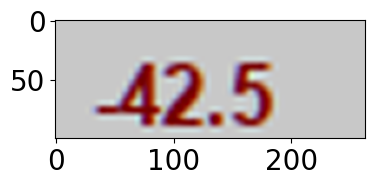

[0, 3]


please help me read this lable:  -42.5


-42.5


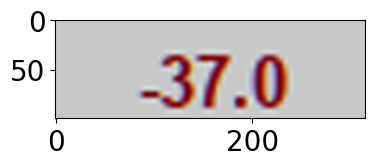

[0, 3]


please help me read this lable:  -37


-37.0

./height_data_zoomed/sc_Vaisala_6_3_.png
20000.0
16000.0
-80.0
-66.0

./height_data_zoomed/sc_Vaisala_6_2_.png
25000.0
21000.0
-70.0
-56.0

./height_data_zoomed/sc_Vaisala_6_5_.png
9000.0
6000.0
-30.0
0.0

./height_data_zoomed/sc_Vaisala_6_1_.png
30000.0
26000.0
-54.0
-42.0

./height_data_zoomed/sc_Vaisala_6_6_.png
4500.0
1000.0
2.0


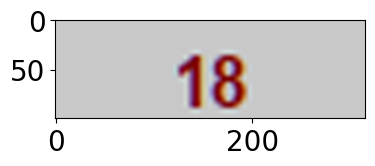

[1]


please help me read this lable:  18


18.0

./height_data_zoomed/sc_Vaisala_7_1_.png
31000.0
27000.0
-51.0
-43.0

./height_data_zoomed/sc_Vaisala_7_2_.png
25000.0
21000.0
-66.0
-53.0

./height_data_zoomed/sc_Vaisala_7_6_.png
5000.0
1500.0
0.0


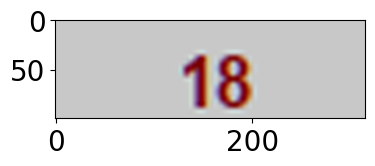

[1]


please help me read this lable:  18


18.0

./height_data_zoomed/sc_Vaisala_7_0_.png
35000.0
31500.0
-44.0
-32.0

./height_data_zoomed/sc_Vaisala_7_3_.png
20000.0
16000.0
-78.0
-65.0

./height_data_zoomed/sc_Vaisala_7_5_.png
10000.0
6000.0
-34.0
-4.0

./height_data_zoomed/sc_Vaisala_7_4_.png
15000.0
11000.0
-74.0
-36.0

./height_data_zoomed/sc_Vaisala_8_0_.png
27500.0
24500.0


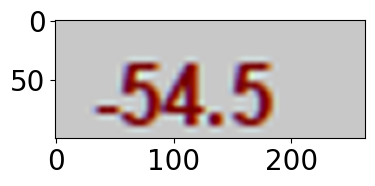

[0, 3]


please help me read this lable:  -54.5


-54.5


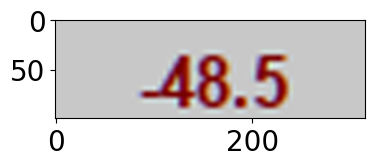

[0, 3]


please help me read this lable:  -48.5


-48.5

./height_data_zoomed/sc_Vaisala_8_6_.png
3500.0
1000.0
6.0
20.0

./height_data_zoomed/sc_Vaisala_8_4_.png
12000.0
8500.0
-48.0
-20.0

./height_data_zoomed/sc_Vaisala_8_5_.png
7500.0
4000.0


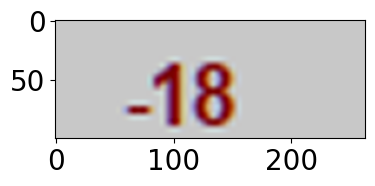

[0, 2]


please help me read this lable:  -18


-18.0
4.0

./height_data_zoomed/sc_Vaisala_8_3_.png
16000.0
12500.0
-76.0
-50.0

./height_data_zoomed/sc_Vaisala_8_2_.png
20000.0
16500.0
-79.0
-68.0

./height_data_zoomed/sc_Vaisala_8_1_.png
24000.0
20500.0
-68.0
-56.0

./height_data_zoomed/sc_Vaisala_9_0_.png
34500.0
31000.0
-43.0
-32.0

./height_data_zoomed/sc_Vaisala_9_6_.png
4500.0
1000.0
2.0
22.0

./height_data_zoomed/sc_Vaisala_9_2_.png
25000.0
21000.0
-66.0
-51.0

./height_data_zoomed/sc_Vaisala_9_3_.png
20000.0
16000.0
-80.0
-66.0

./height_data_zoomed/sc_Vaisala_9_1_.png
30000.0
26000.0
-53.0
-44.0

./height_data_zoomed/sc_Vaisala_9_5_.png
10000.0
6000.0
-34.0
-2.0

./height_data_zoomed/sc_Vaisala_9_4_.png
15000.0
11000.0
-70.0
-35.0

./height_data_zoomed/sc_Vaisala_10_6_.png
4500.0
1000.0
2.0


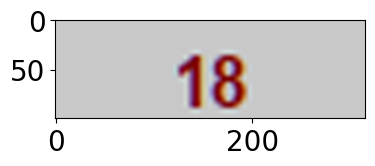

[1]


please help me read this lable:  18


18.0

./height_data_zoomed/sc_Vaisala_10_3_.png
19000.0
15000.0
-79.0
-66.0

./height_data_zoomed/sc_Vaisala_10_1_.png
29000.0
25000.0
-55.0
-48.0

./height_data_zoomed/sc_Vaisala_10_0_.png
32500.0
29000.0
-46.0
-37.0

./height_data_zoomed/sc_Vaisala_10_5_.png
9500.0
5500.0
-28.0
0.0

./height_data_zoomed/sc_Vaisala_10_4_.png
14000.0
10000.0
-68.0
-30.0

./height_data_zoomed/sc_Vaisala_10_2_.png
24000.0
20000.0
-72.0
-58.0



In [58]:
# for j in range(1,11):
for j in range(4,11,1):
    for i in glob.glob('./height_data_zoomed/sc_Vaisala_'+str(j)+'_*_.png'): # MKII_'+str(j)+'
        df = digitize(i, height_input = True)

In [59]:
vais_df = pd.read_csv('./vaisala_ascents.csv')
asc_list = list(vais_df.date_time.drop_duplicates())
asc_list

['07-02-2005 10:01:53.551',
 '07-02-2005 14:57:50.481',
 '07-02-2005 19:31:41.965',
 '08-02-2005 05:13:16.722',
 '08-02-2005 10:00:56.553',
 '08-02-2005 15:03:03.289',
 '08-02-2005 19:33:03.372',
 '09-02-2005 05:12:00.618',
 '09-02-2005 10:05:05.418',
 '09-02-2005 14:59:48.197',
 '09-02-2005 19:17:51.222',
 '10-02-2005 05:02:13.432',
 '10-02-2005 09:58:41.940',
 '10-02-2005 14:57:54.734',
 '10-02-2005 19:00:19.242',
 '11-02-2005 05:02:45.185',
 '11-02-2005 15:05:21.407',
 '11-02-2005 18:31:58.407',
 '12-02-2005 15:00:05.867',
 '12-02-2005 18:36:55.168',
 '14-02-2005 05:06:57.494',
 '14-02-2005 10:08:04.684',
 '14-02-2005 15:00:54.504',
 '14-02-2005 18:00:36.448',
 '15-02-2005 05:16:46.851',
 '15-02-2005 10:03:06.727',
 '15-02-2005 15:01:34.429',
 '15-02-2005 18:11:25.926',
 '16-02-2005 05:11:08.125',
 '16-02-2005 10:03:34.821',
 '17-02-2005 10:15:24.825',
 '17-02-2005 14:59:11.401',
 '17-02-2005 18:03:18.602',
 '18-02-2005 05:13:26.446',
 '18-02-2005 10:07:00.508',
 '18-02-2005 14:59:1

In [49]:
def find_nearest(array, value, array_matching = np.nan):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if np.isnan(array_matching).all():
        return array[idx]
    else:
        return array_matching[idx]

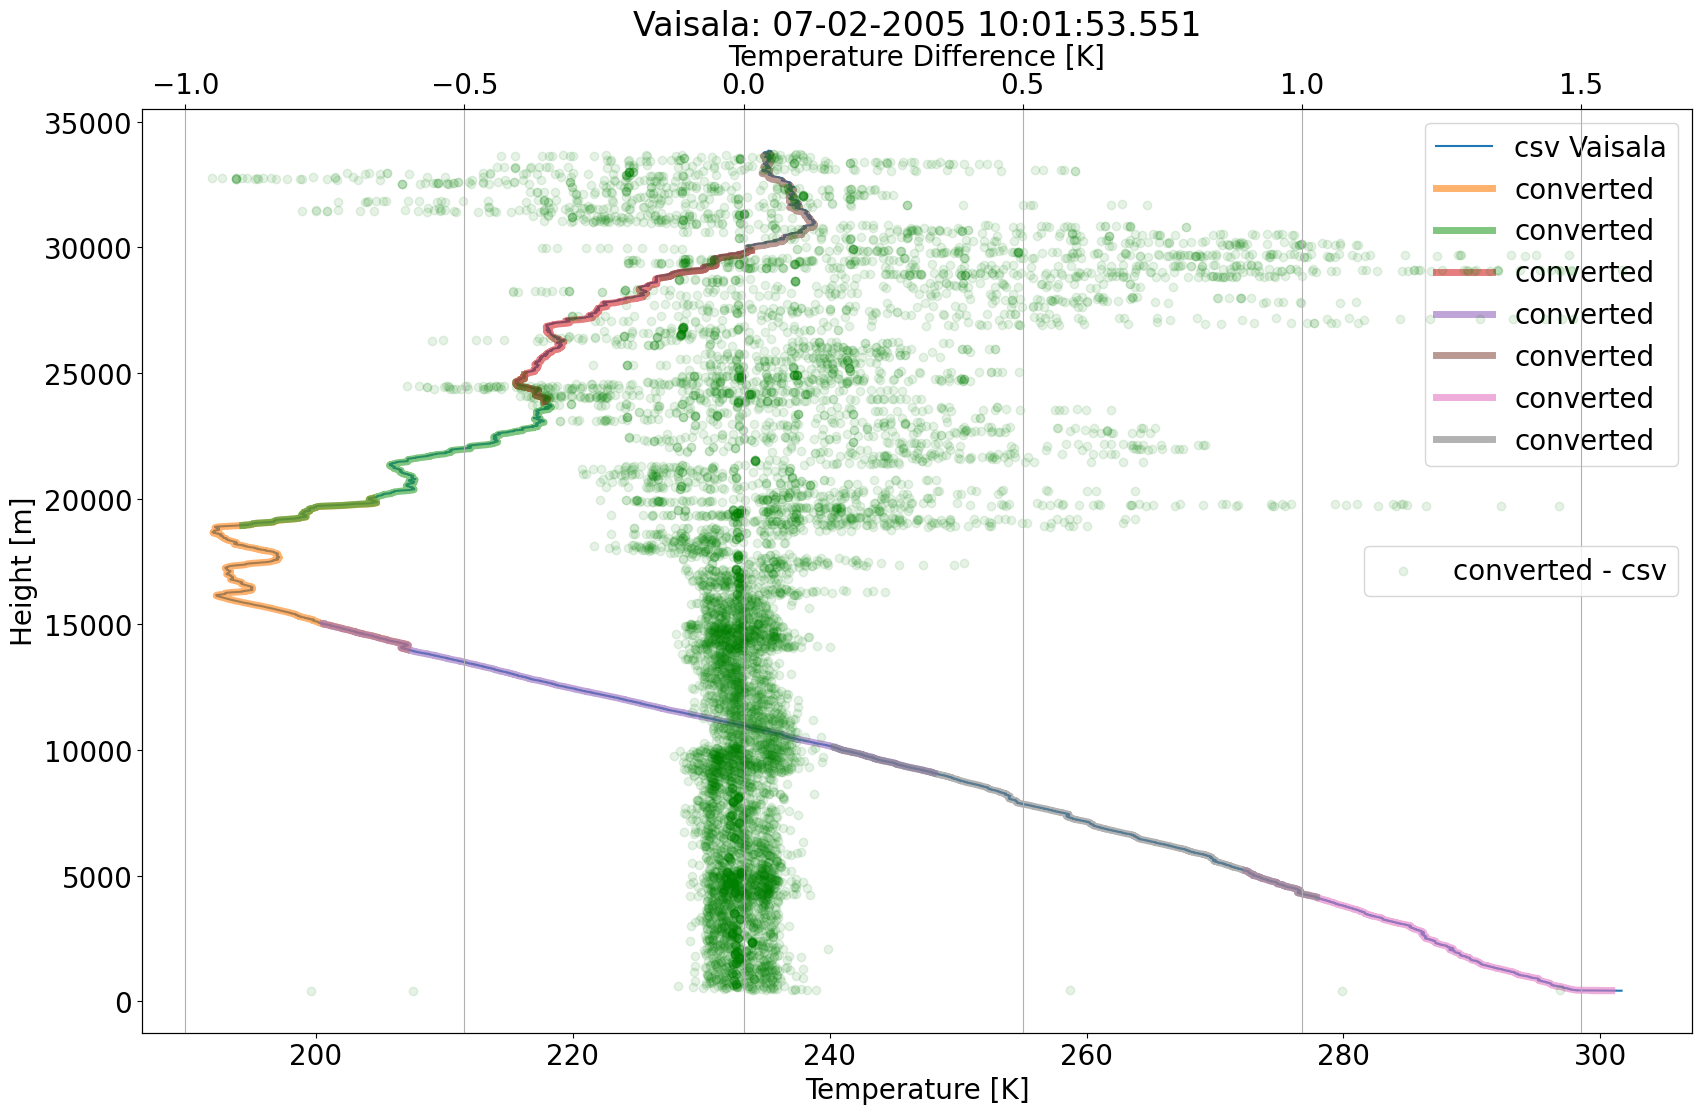

0.060098876345486225


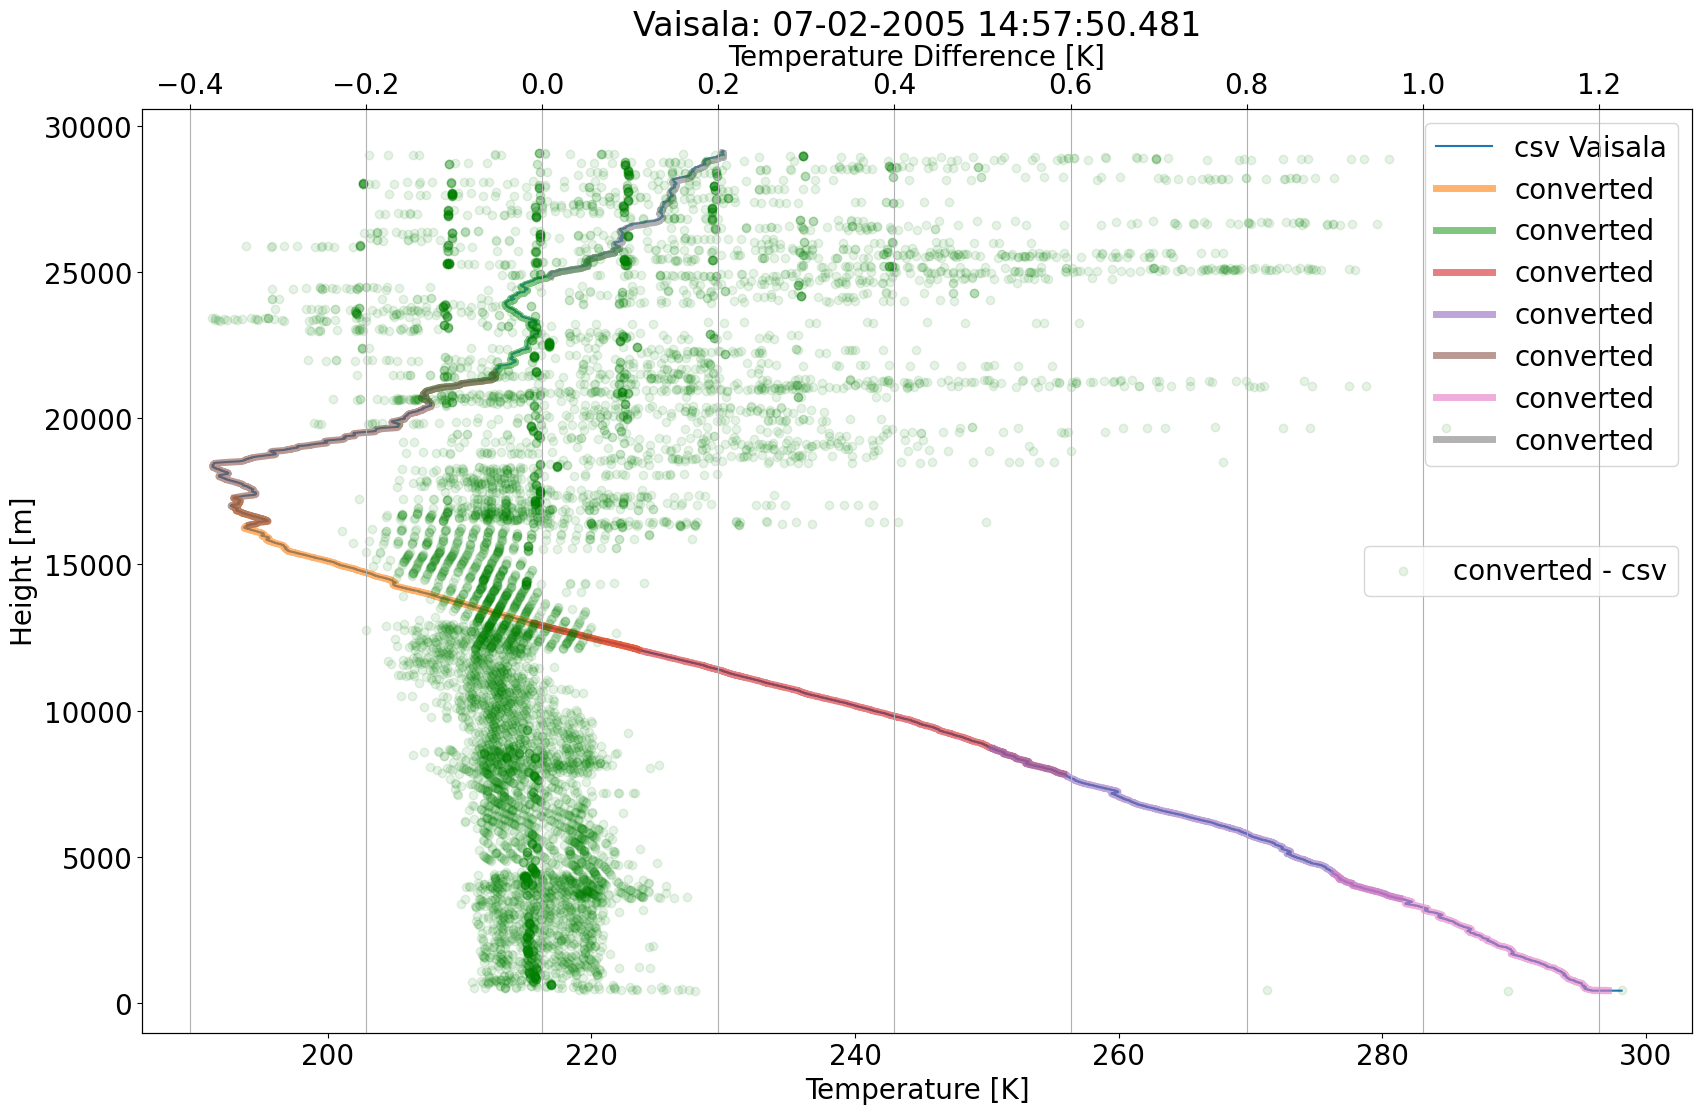

0.04706683403012851


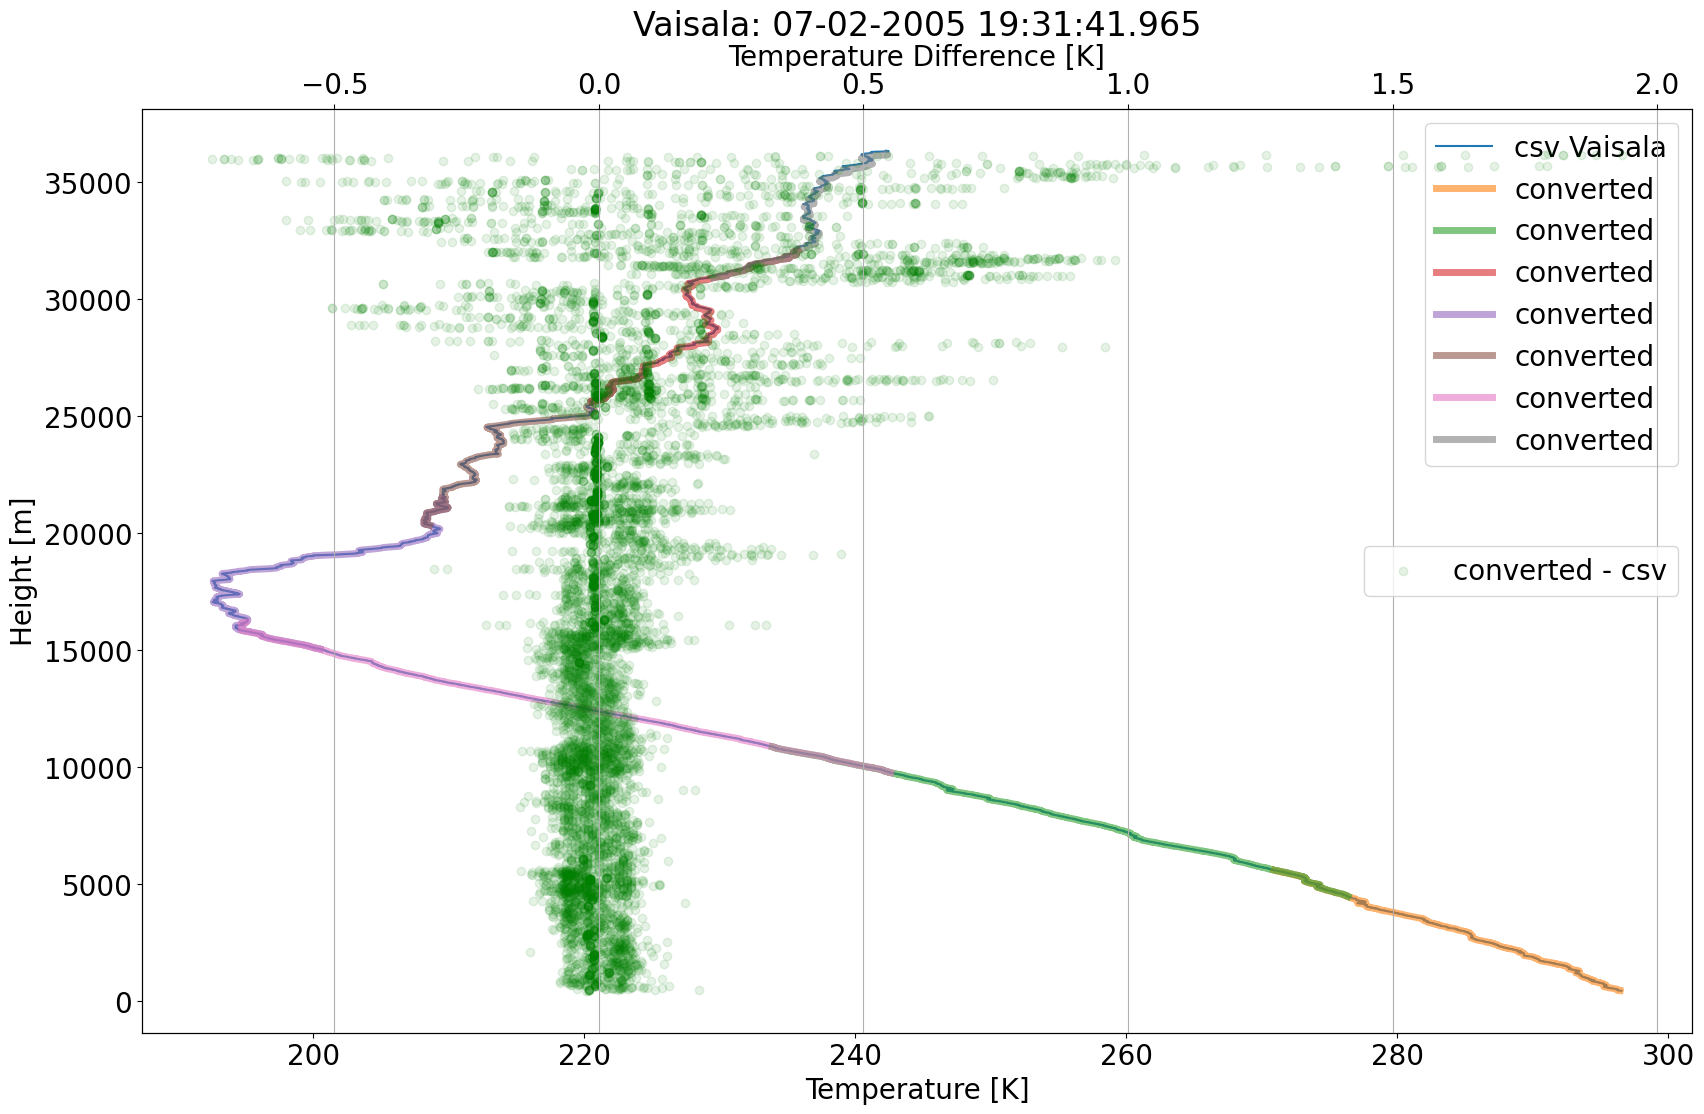

0.058477960504290036


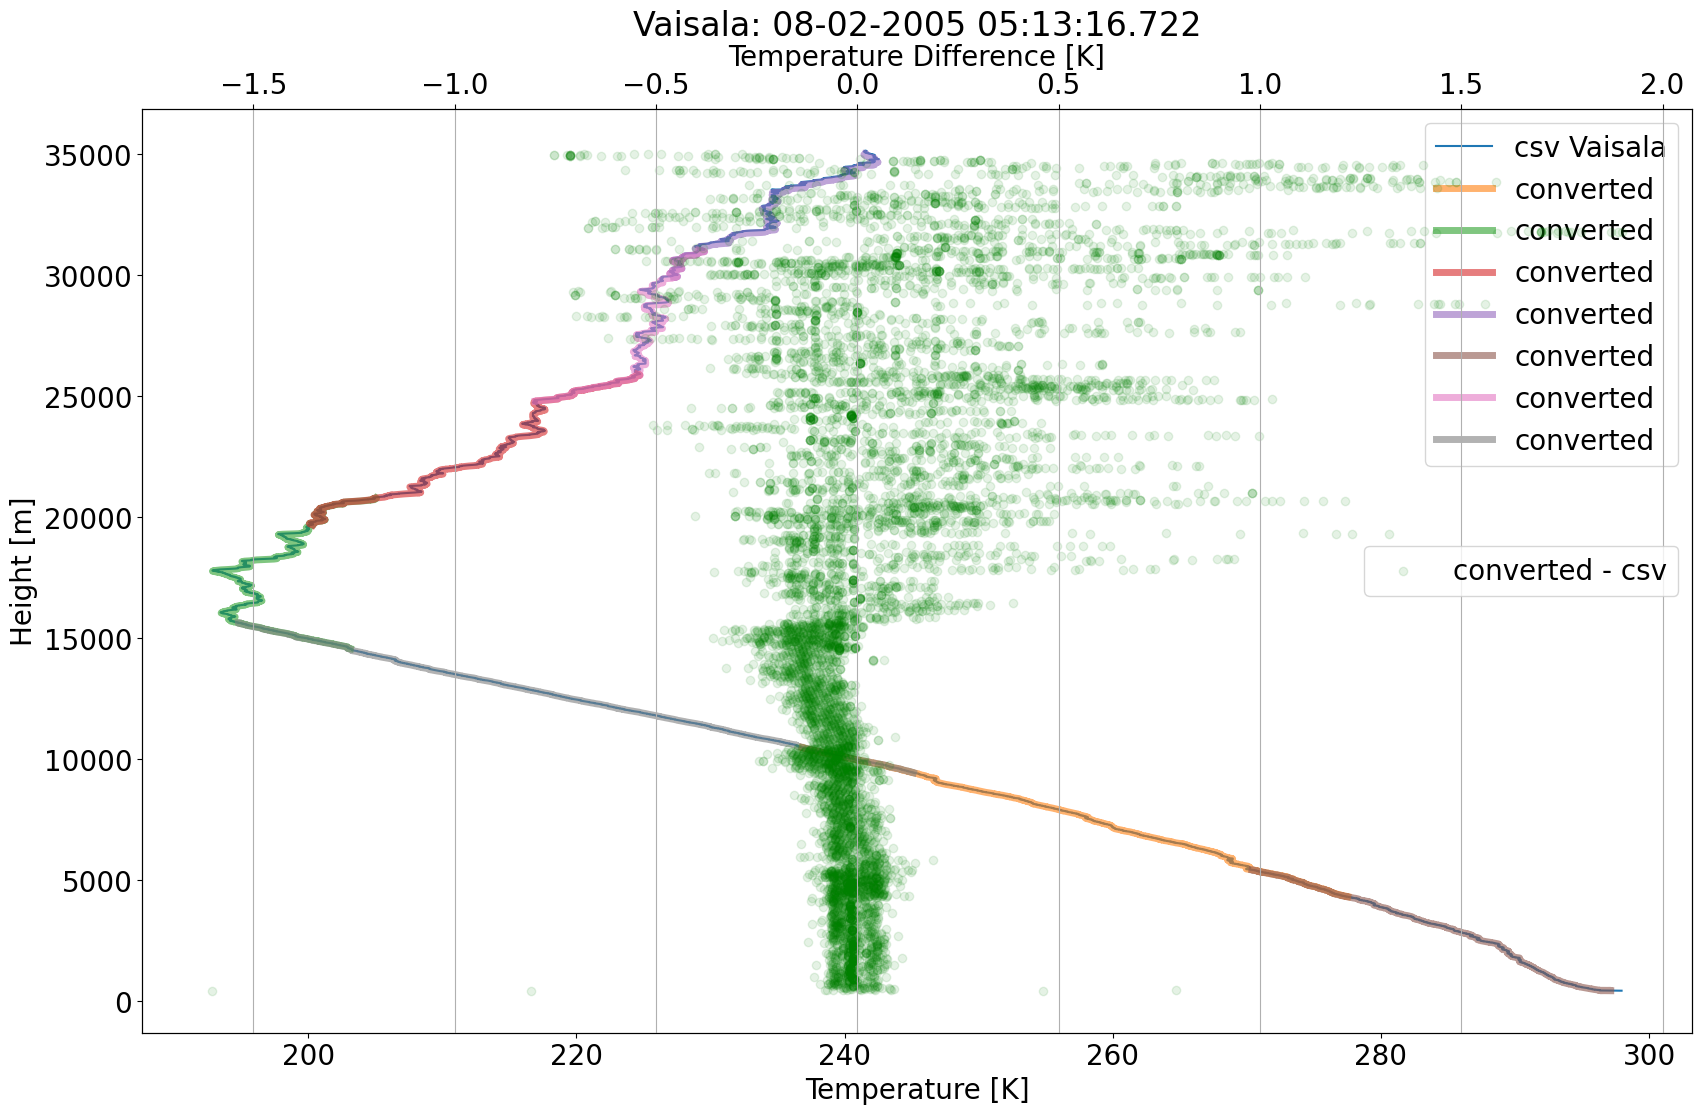

0.06515119500456763


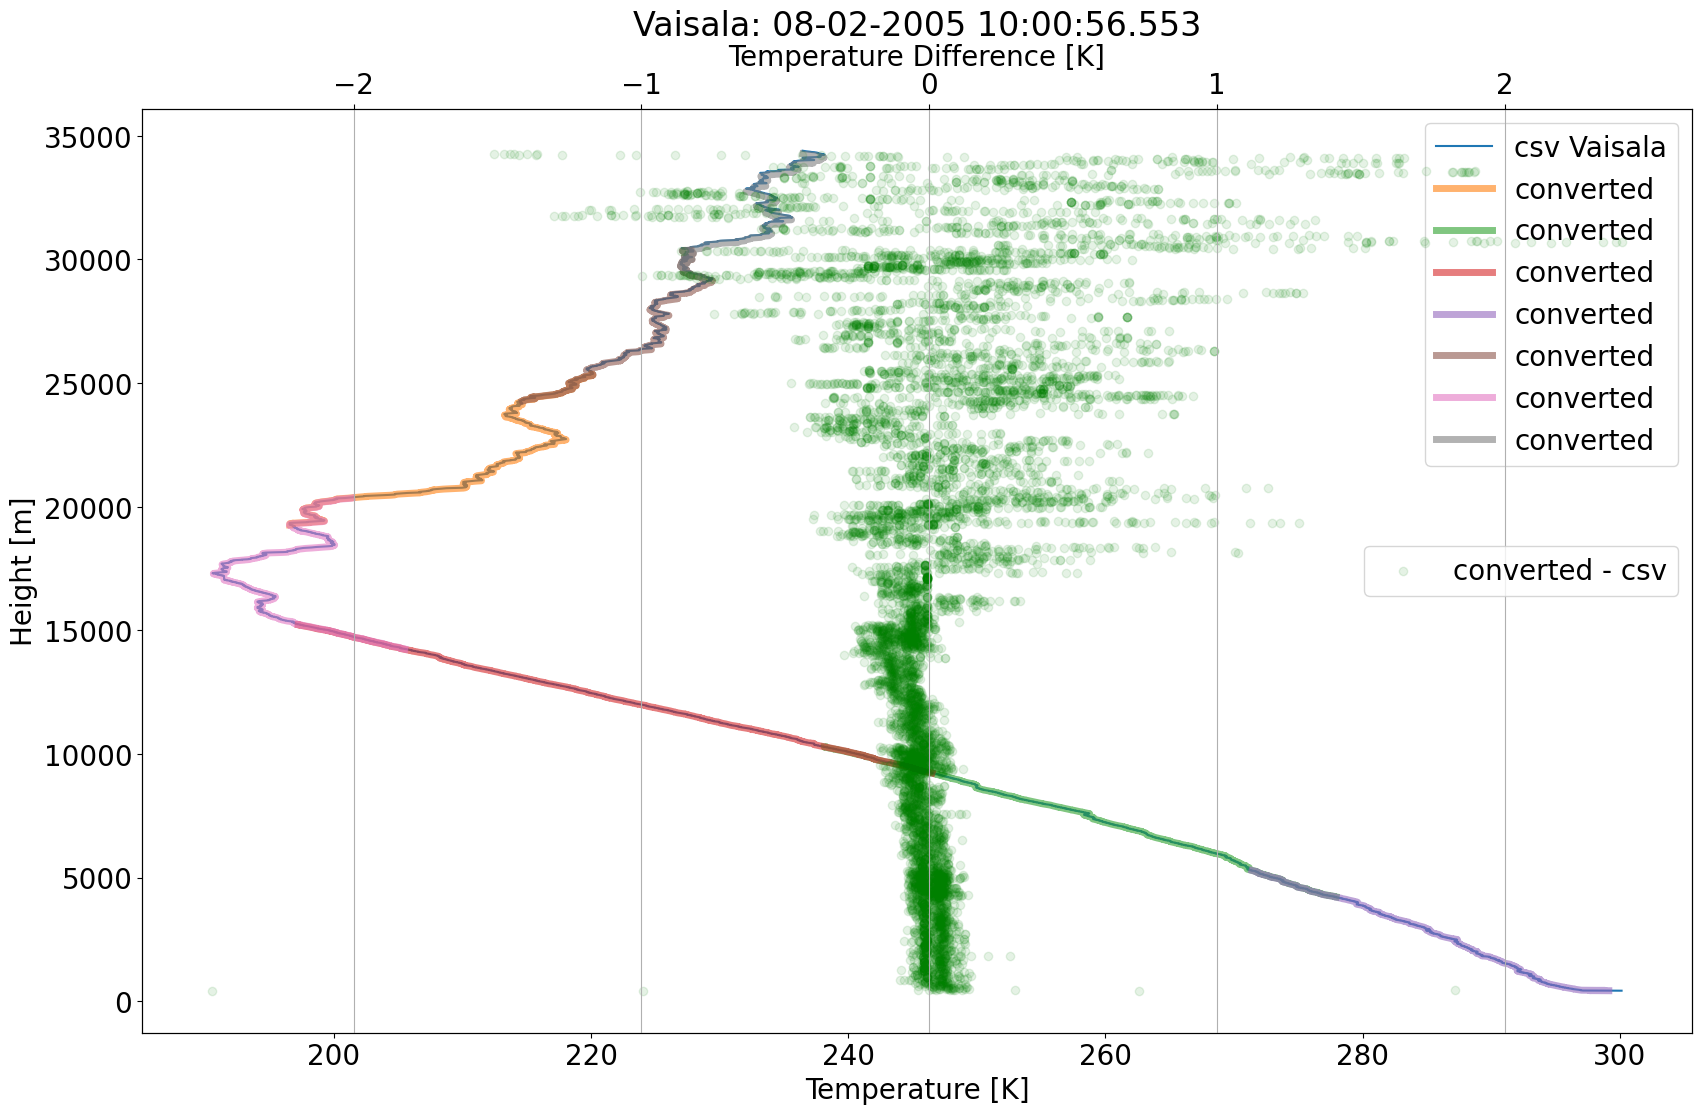

0.04725320500654885


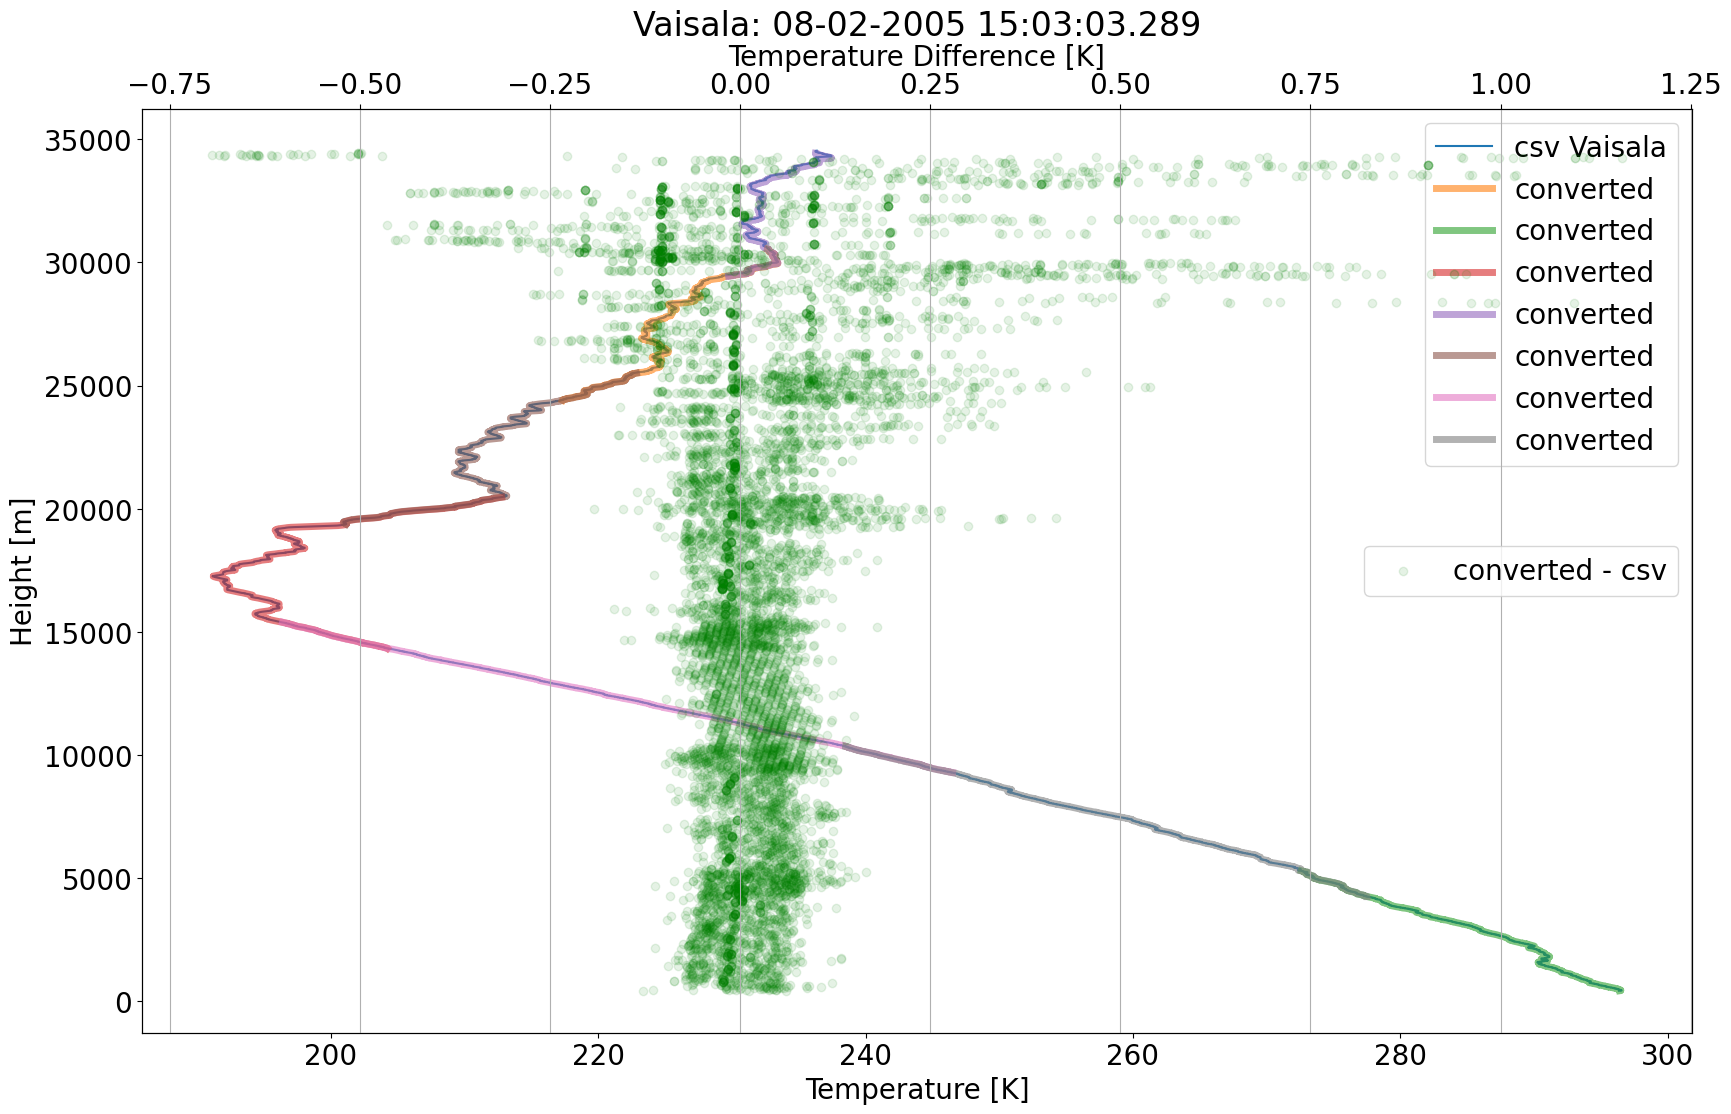

0.03667651282244049


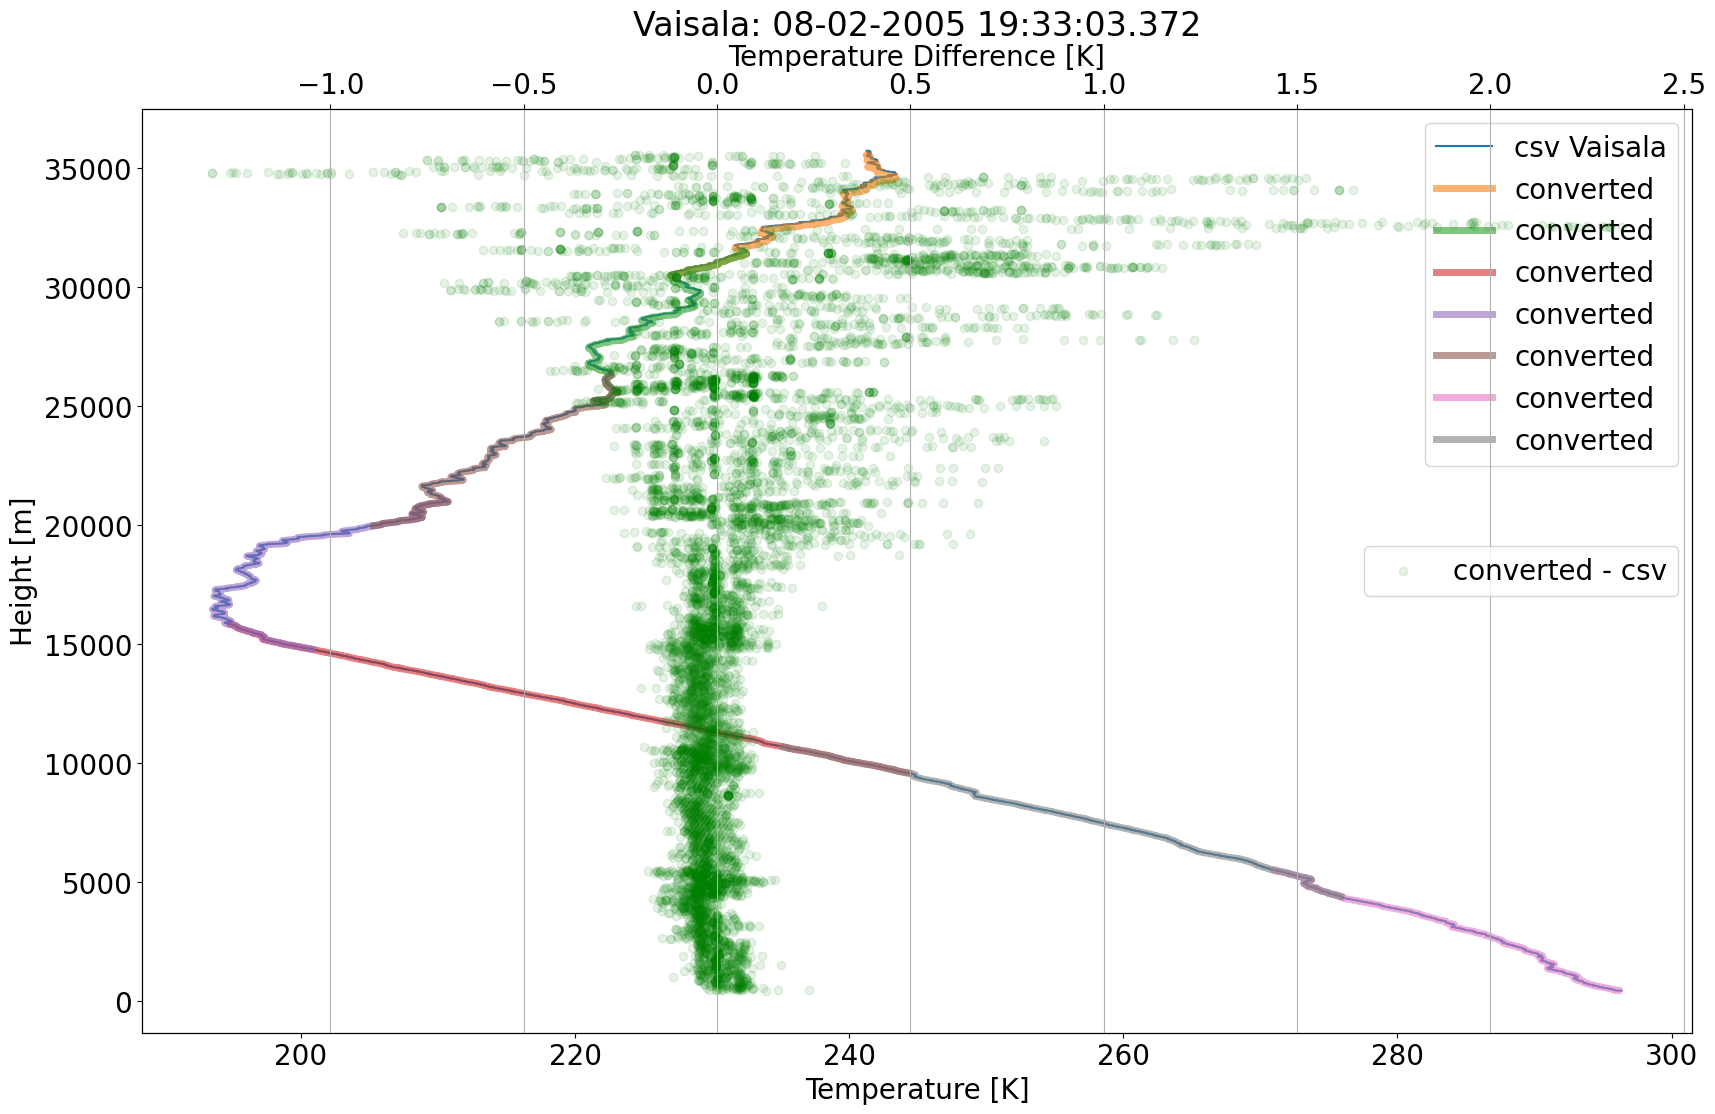

0.07087719886940386


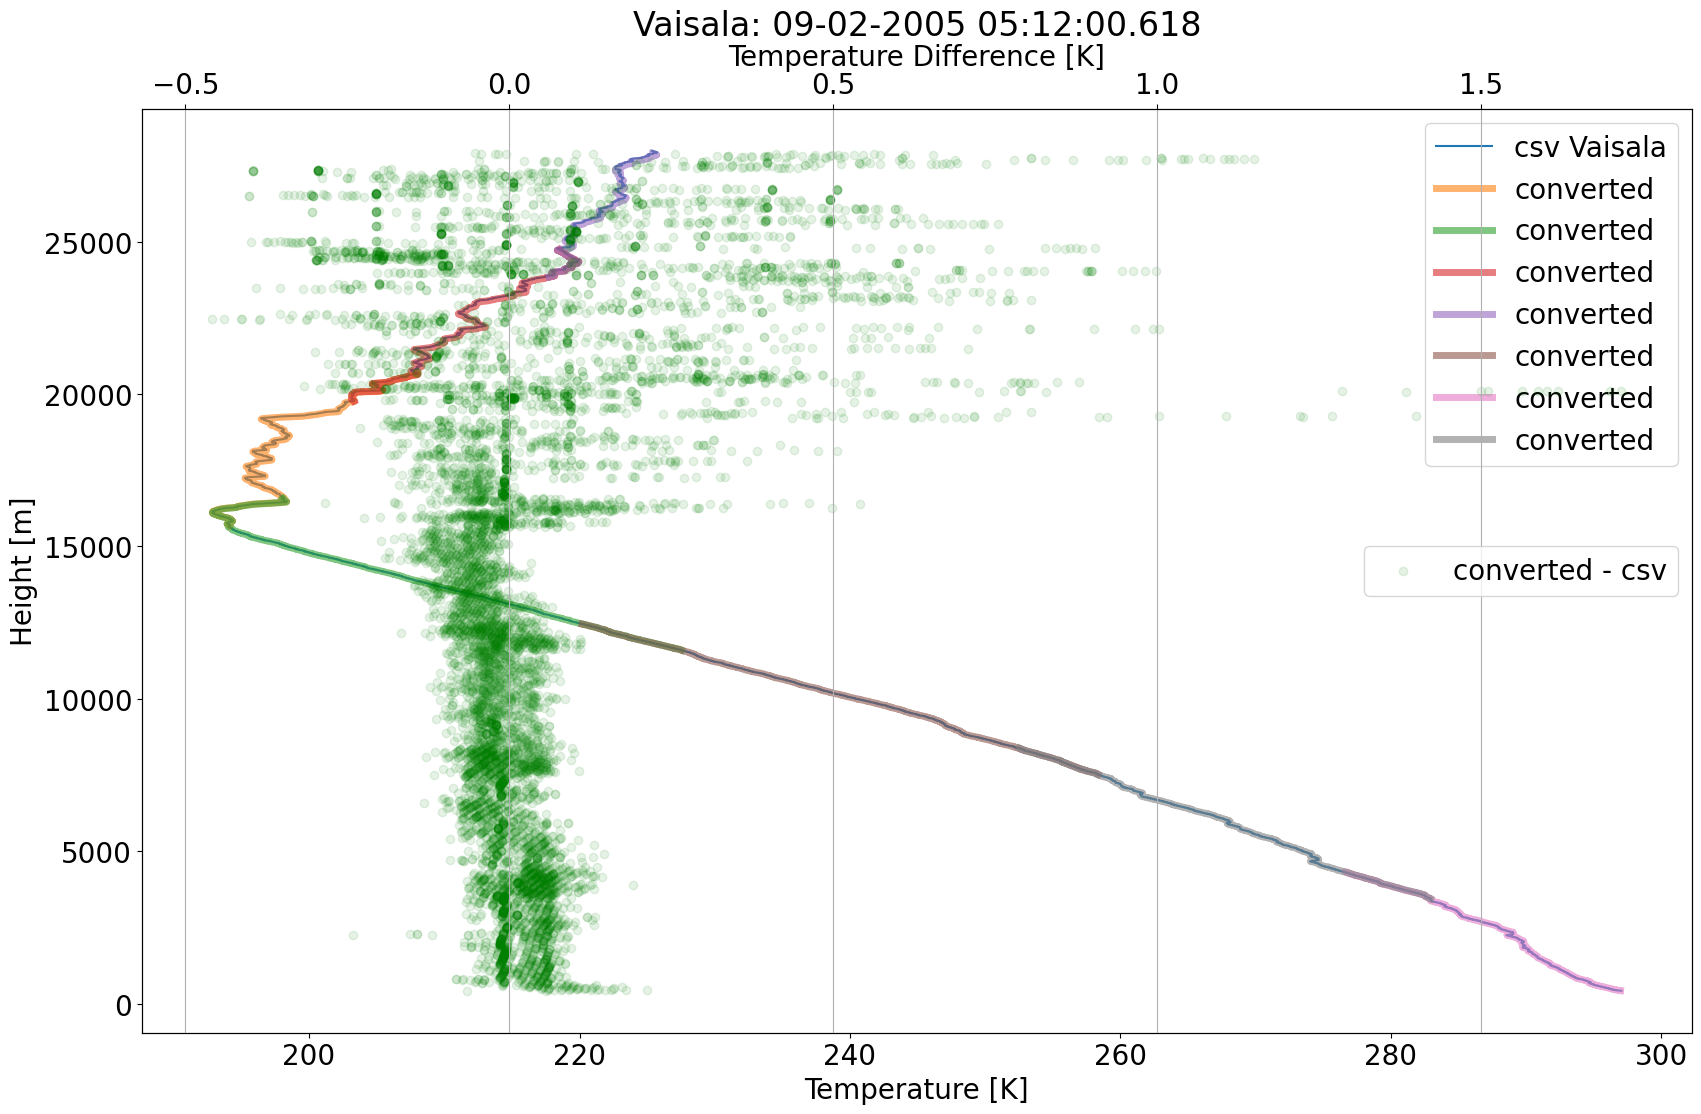

0.03801123854637804


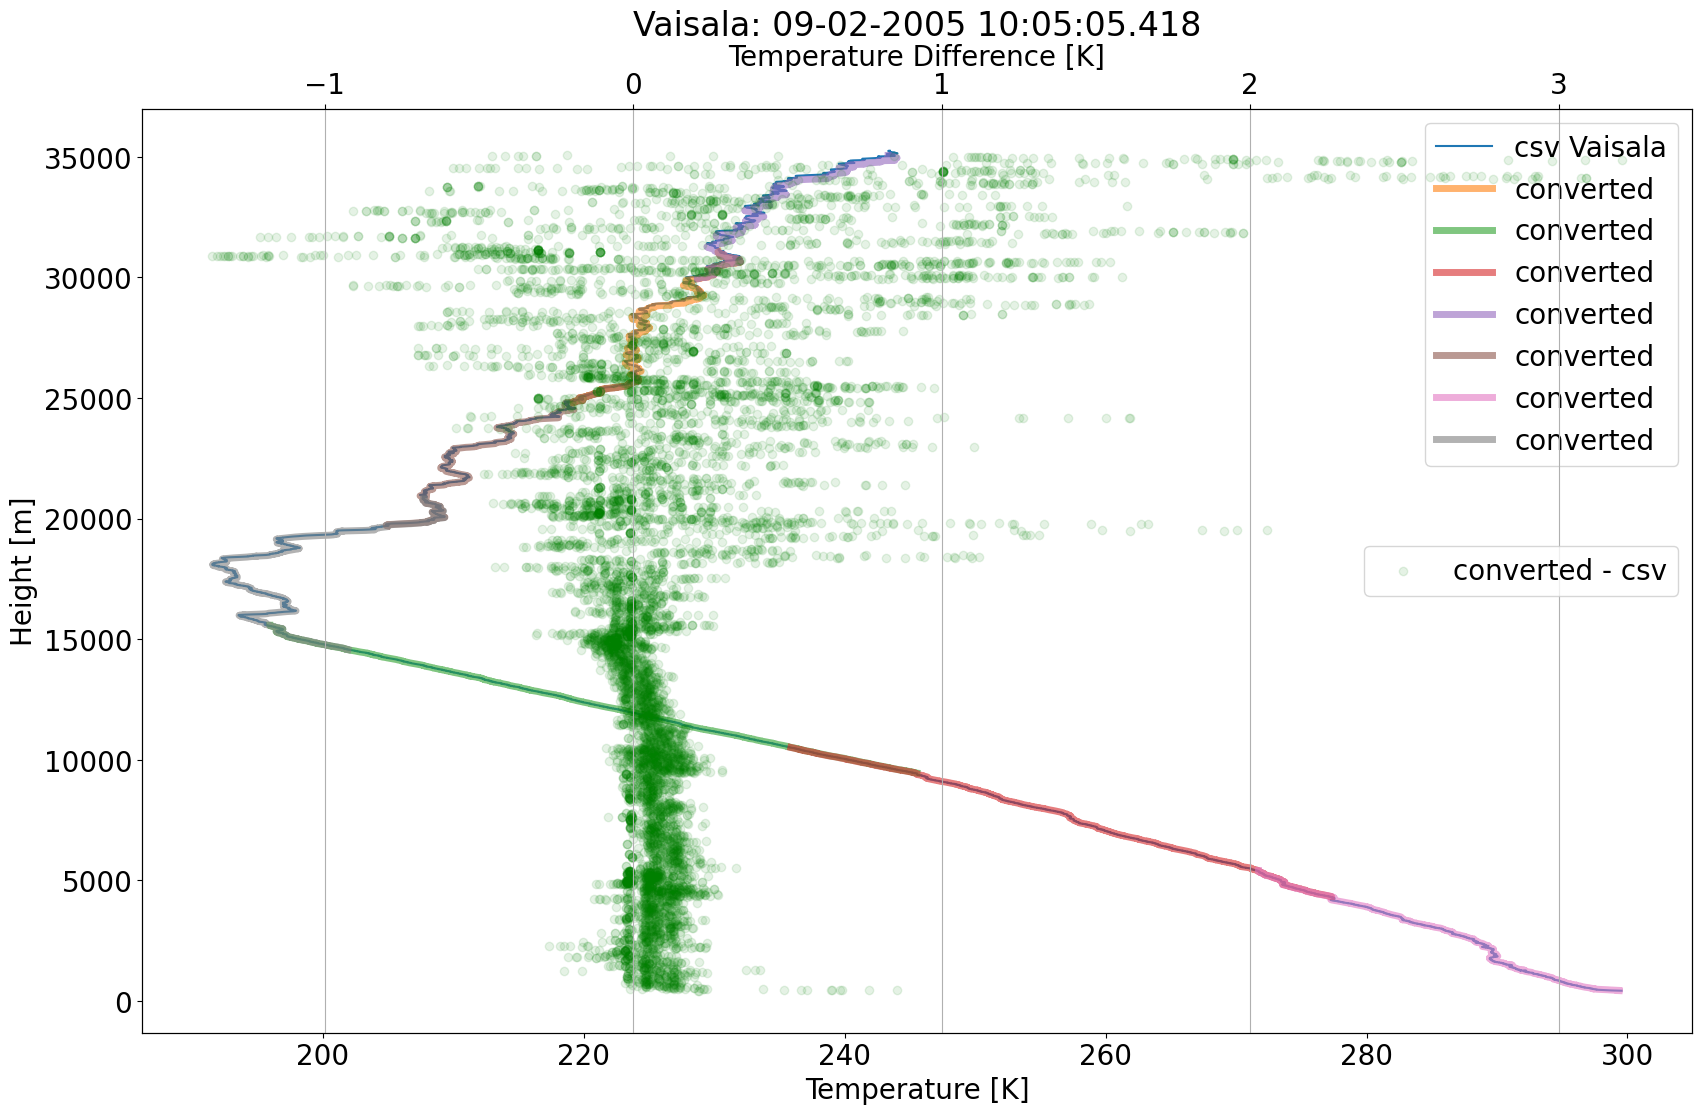

0.14630865065683285


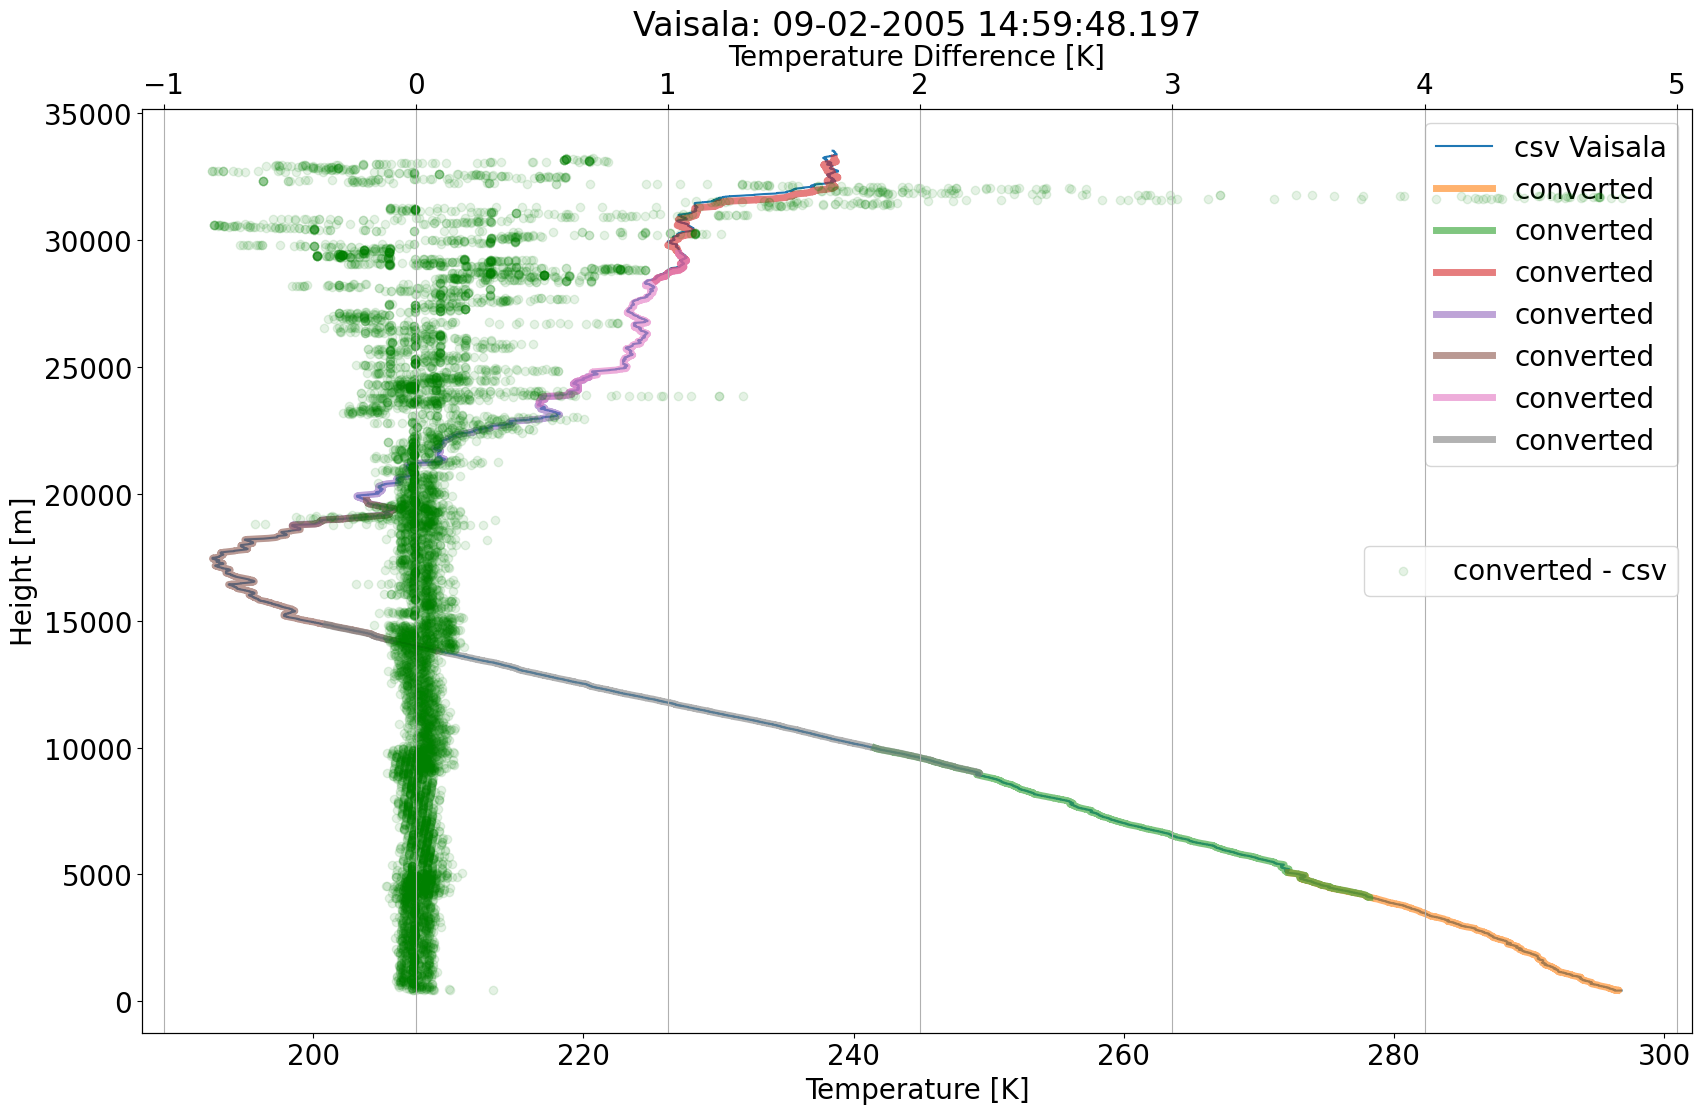

0.10028441038523957


In [60]:
matplotlib.rcParams["figure.figsize"] = (20, 12)
ascs = asc_list[:10] #['07-02-2005 10:01:53.551', '07-02-2005 14:57:50.481', '07-02-2005 19:31:41.965']
for i in range(len(ascs)):
    vais_df = pd.read_csv('./vaisala_ascents.csv')
    vais_df = vais_df[vais_df.date_time == ascs[i]]
    vais_df = vais_df[vais_df.height > 0]
    vais_df.temperature = vais_df.temperature + 273.15
    plt.plot(vais_df.temperature, vais_df.height, label='csv Vaisala')#, alpha = 0.4, linewidth = 6)
    
    diff = []
    diff_y = []
    for j in glob.glob('./out_height_zoomed/Vaisala_'+str(i+1)+'_*_.csv')[:]:
        df = pd.read_csv(j)
        plt.plot(df.temp, df.press, alpha = 0.6, linewidth = 5, label='converted')
        diff_interm = []
        for lev_p, lev_t in zip(df.press, df.temp):
            diff_interm.append(lev_t - find_nearest(np.array(vais_df.height), lev_p, np.array(vais_df.temperature)))
        diff_y.extend(df.press)
        diff.extend(diff_interm)
    plt.legend()
    plt.title('Vaisala: ' + ascs[i])
    ax = plt.gca()
    ax.set_xlabel('Temperature [K]')
    ax.set_ylabel('Height [m]')
    # ax.set_yscale('log')
    # ax.set_ylim(ax.get_ylim()[::-1])
    
    ax2= ax.twiny()
    ax2.set_xlabel('Temperature Difference [K]')
    ax2.grid()
    # diff = []
    # for lev_p, lev_t in zip(df.press, df.temp):
    #     diff.append(lev_t - find_nearest(np.array(vais_df.height), lev_p, np.array(vais_df.temperature)))
    ax2.scatter(diff, diff_y, color='green', alpha = 0.1, label = 'converted - csv')
    ax2.legend(loc='center right')
    plt.show()
    plt.close()
    print(np.mean(diff))
